# Notebook for your task :3

In [43]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import torch
import torch.nn as rnn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

# load data

In [44]:
# Load data
# Load datasets with datetime parsing
train_df = pd.read_csv("TrainData.csv", parse_dates=['TIMESTAMP'])
solution_df = pd.read_csv("Solution.csv", parse_dates=['TIMESTAMP'])
template_df = pd.read_csv("ForecastTemplate.csv", parse_dates=['TIMESTAMP'])

# only use timestamp and power according to task 3
train_df = train_df[['TIMESTAMP', 'POWER']]

# creating lag features

In [45]:
# Create lag features
def create_lag_features(df, window_size=24):
    df_lagged = df.copy()
    for lag in range(1, window_size + 1):
        df_lagged[f'lag_{lag}'] = df_lagged['POWER'].shift(lag)
    return df_lagged.dropna()

In [46]:
# Create combined dataset for continuity in time series
combined_df = pd.concat([train_df, solution_df], ignore_index=True)
combined_df.sort_values('TIMESTAMP', inplace=True)

# Apply lag feature creation
window_size = 24
combined_lagged = create_lag_features(combined_df, window_size)

In [47]:
# Split the lagged data into train and forecast sets
train_sized = combined_lagged[combined_lagged['TIMESTAMP'] < pd.to_datetime('2013-11-01')]
forecast_df = combined_lagged[
    (combined_lagged['TIMESTAMP'] >= pd.to_datetime('2013-11-01')) &
    (combined_lagged['TIMESTAMP'] <= pd.to_datetime('2013-11-30 23:00:00'))
]


In [48]:
# Prepare features and target
x_train = train_sized.drop(columns=['TIMESTAMP', 'POWER'])
y_train = train_sized['POWER'].values.reshape(-1, 1)

In [49]:
# Scale features and target
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
x_train_scaled = feature_scaler.fit_transform(x_train)
y_train_scaled = target_scaler.fit_transform(y_train)

# Train LR

In [50]:
# Train LR model 
lr_model = LinearRegression()
lr_model.fit(x_train_scaled, y_train_scaled)

LinearRegression()

# Train SVR

In [51]:
# Train Support Vector Regression using RBF Kernel
svr_model = SVR(kernel='rbf')
svr_model.fit(x_train_scaled, y_train_scaled.ravel())


SVR()

# Train ANN

In [52]:
# Train Artificial Neural Network Model
ann_model = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, early_stopping=True)
ann_model.fit(x_train_scaled, y_train_scaled.ravel())

MLPRegressor(early_stopping=True, hidden_layer_sizes=(64, 32), max_iter=1000)

In [53]:
import random

SEED = random.randint(0, 2**32 - 1) # set a seed to reproduce the data
# seed from paper: 1599032271
SEED = 1599032271
print(f"Random seed used: {SEED}")
torch.manual_seed(SEED)

# Recurrent Neural Network Model Definition
class RNNModel(rnn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(RNNModel, self).__init__()
        self.RNN = rnn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = rnn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out, _ = self.RNN(x)
        out = self.fc(out[:, -1, :])
        return out

Random seed used: 1599032271


In [54]:
x_tensor = torch.from_numpy(x_train_scaled.reshape(-1, window_size, 1).astype(np.float32))
y_tensor = torch.from_numpy(y_train_scaled.astype(np.float32))

full_dataset = TensorDataset(x_tensor, y_tensor)
train_len = int(len(full_dataset) * 0.8)
val_len = len(full_dataset) - train_len
train_dataset, val_dataset = random_split(full_dataset, [train_len, val_len])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Train RNN

In [55]:
# Train RNN Model
rnn_model = RNNModel()
criterion = rnn.MSELoss()
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001)
# adding a scheduler to optimize learning rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

# Lists to store loss values
train_losses = []
val_losses = []

# early stopping
min_epochs = 30 # minimum epoch count
best_val_loss = float('inf')
patience = 10  # how many epochs of not improving MSE it waits until it stops
counter = 0
best_model_state = None

for epoch in range(100):
    rnn_model.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        output = rnn_model(x_batch)
        loss = criterion(output, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss_avg = train_loss / len(train_loader)
    train_losses.append(train_loss_avg)
        
    # Validation
    rnn_model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            output = rnn_model(x_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item()
    
    val_loss_avg = val_loss / len(val_loader)
    val_losses.append(val_loss_avg)
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr != old_lr:
        print(f"Learning rate reduced from {old_lr:.6f} to {new_lr:.6f}")
            
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(val_loader):.4f}")
    
    # Early stopping check
    if val_loss_avg < best_val_loss:
        best_val_loss = val_loss_avg
        counter = 0
        best_model_state = rnn_model.state_dict()
    else:
        counter += 1
        if counter >= patience and epoch + 1 >= min_epochs:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

Epoch 1, Train Loss: 0.0977, Val Loss: 0.1024
Epoch 2, Train Loss: 0.0793, Val Loss: 0.0618
Epoch 3, Train Loss: 0.0999, Val Loss: 0.1011
Epoch 4, Train Loss: 0.0299, Val Loss: 0.0139
Epoch 5, Train Loss: 0.0132, Val Loss: 0.0138
Epoch 6, Train Loss: 0.0126, Val Loss: 0.0142
Epoch 7, Train Loss: 0.0124, Val Loss: 0.0159
Epoch 8, Train Loss: 0.0122, Val Loss: 0.0158
Epoch 9, Train Loss: 0.0120, Val Loss: 0.0137
Epoch 10, Train Loss: 0.0119, Val Loss: 0.0141
Epoch 11, Train Loss: 0.0119, Val Loss: 0.0140
Epoch 12, Train Loss: 0.0119, Val Loss: 0.0135
Epoch 13, Train Loss: 0.0119, Val Loss: 0.0136
Epoch 14, Train Loss: 0.0118, Val Loss: 0.0122
Epoch 15, Train Loss: 0.0118, Val Loss: 0.0121
Epoch 16, Train Loss: 0.0117, Val Loss: 0.0133
Epoch 17, Train Loss: 0.0117, Val Loss: 0.0124
Epoch 18, Train Loss: 0.0117, Val Loss: 0.0125
Epoch 19, Train Loss: 0.0117, Val Loss: 0.0143
Epoch 20, Train Loss: 0.0116, Val Loss: 0.0117
Epoch 21, Train Loss: 0.0115, Val Loss: 0.0118
Epoch 22, Train Loss: 

the code above trains a RNN model. Here we defined the training loop for up to 100 epochs.
Training phase: where for each batch, it does forward pass, loss computation, backward and, finally, parameter update. It tracks and store averages training loss per epoch.
Validation phase: evaluates model on the validation set without updating weights and, tracks and stores average validation loss per epoch.
if validation loss does not improve, the scheduler automatically reduces the learning rate to fine-tune the training. Also if validation loss does not improve for a number of consecutive epochs (patience = 10), and at least (min_epochs = 30) have passed, training stops early to prevent overfitting. It keeps tracks of the best model state based on validation loss.

In [56]:
# Forecasting
x_pred = forecast_df.drop(columns=['TIMESTAMP', 'POWER'])
x_pred_scaled = feature_scaler.transform(x_pred)

y_pred_lr_scaled = lr_model.predict(x_pred_scaled)
y_pred_lr = target_scaler.inverse_transform(y_pred_lr_scaled).flatten()

y_pred_svr_scaled = svr_model.predict(x_pred_scaled)
y_pred_svr = target_scaler.inverse_transform(y_pred_svr_scaled.reshape(-1, 1)).flatten()

y_pred_ann_scaled = ann_model.predict(x_pred_scaled)
y_pred_ann = target_scaler.inverse_transform(y_pred_ann_scaled.reshape(-1, 1)).flatten()

x_pred_tensor = torch.from_numpy(x_pred_scaled.reshape(-1, window_size, 1).astype(np.float32))
rnn_model.eval()
with torch.no_grad():
    y_pred_rnn_scaled = rnn_model(x_pred_tensor).numpy() 
y_pred_rnn = target_scaler.inverse_transform(y_pred_rnn_scaled).flatten()

In [57]:
# Save forecasts
def save_forecast(filename, predictions):
    pd.DataFrame({
        'TIMESTAMP': template_df['TIMESTAMP'],
        'POWER': predictions
    }).to_csv(filename, index=False)

save_forecast("ForecastTemplate3-LR.csv", y_pred_lr)
save_forecast("ForecastTemplate3-SVR.csv", y_pred_svr)
save_forecast("ForecastTemplate3-ANN.csv", y_pred_ann)
save_forecast("ForecastTemplate3-RNN.csv", y_pred_rnn)

In [58]:
# RMSE
true_power = solution_df['POWER'].values
rmse_lr = sqrt(mean_squared_error(true_power, y_pred_lr))
rmse_svr = sqrt(mean_squared_error(true_power, y_pred_svr))
rmse_ann = sqrt(mean_squared_error(true_power, y_pred_ann))
rmse_rnn = sqrt(mean_squared_error(true_power, y_pred_rnn))

rmse_results_df = pd.DataFrame({
    'Model': ['LR', 'SVR', 'ANN', 'RNN'],
    'RMSE': [rmse_lr, rmse_svr, rmse_ann, rmse_rnn]
})

print(f"Forecast RMSE Evaluation Nov 2013")
print(rmse_results_df.sort_values(by='RMSE'))

Forecast RMSE Evaluation Nov 2013
  Model      RMSE
3   RNN  0.179037
1   SVR  0.184302
2   ANN  0.186130
0    LR  0.187384


In [59]:
# Evaluating SMAPE (more stable MAPE when values are close to zero)
smape_lr = 100 * np.mean(2 * np.abs(y_pred_lr - true_power) / (np.abs(true_power) + np.abs(y_pred_lr) + 1e-3))
accuracy_lr = 100 - smape_lr
smape_svr = 100 * np.mean(2 * np.abs(y_pred_svr - true_power) / (np.abs(true_power) + np.abs(y_pred_svr) + 1e-3))
accuracy_svr = 100 - smape_svr
smape_ann = 100 * np.mean(2 * np.abs(y_pred_ann - true_power) / (np.abs(true_power) + np.abs(y_pred_ann) + 1e-3))
accuracy_ann = 100 - smape_ann
smape_rnn = 100 * np.mean(2 * np.abs(y_pred_rnn - true_power) / (np.abs(true_power) + np.abs(y_pred_rnn) + 1e-3))
accuracy_rnn = 100 - smape_rnn
print(f"LR Prediction Accuracy (SMAPE): {accuracy_lr:.2f}%")
print(f"SVR Prediction Accuracy (SMAPE): {accuracy_svr:.2f}%")
print(f"ANN Prediction Accuracy (SMAPE): {accuracy_ann:.2f}%")
print(f"RNN Prediction Accuracy (SMAPE): {accuracy_rnn:.2f}%")

LR Prediction Accuracy (SMAPE): 41.39%
SVR Prediction Accuracy (SMAPE): 42.85%
ANN Prediction Accuracy (SMAPE): 41.39%
RNN Prediction Accuracy (SMAPE): 42.75%


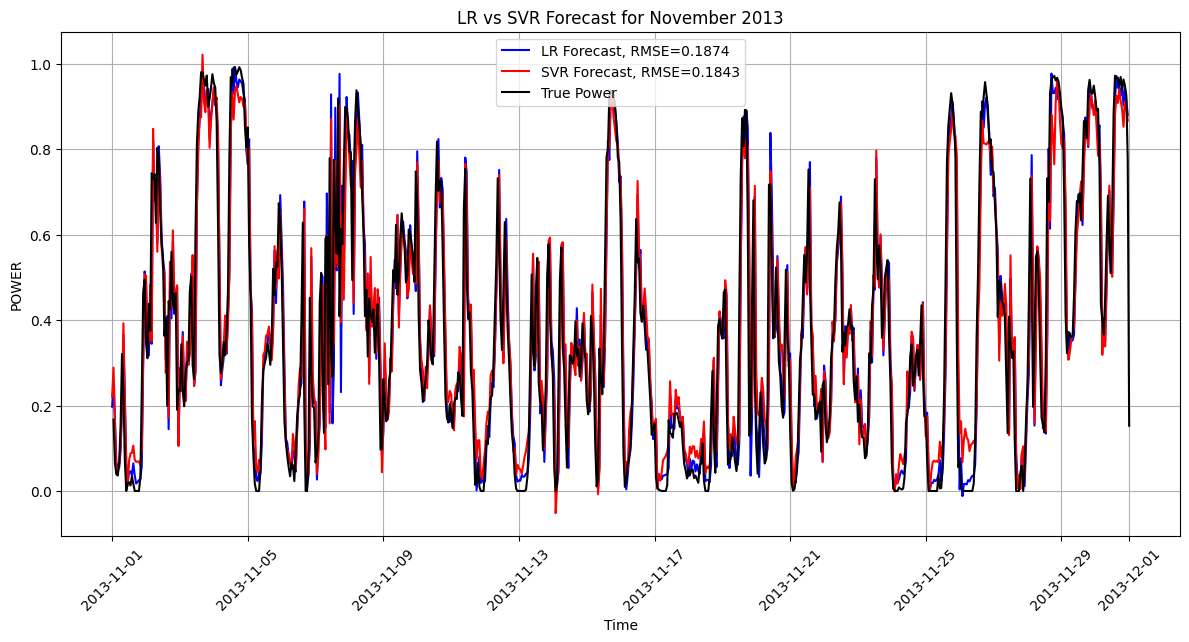

In [60]:
# Plot LR vs SVR
plt.figure(figsize=(12, 6))
plt.plot(forecast_df['TIMESTAMP'], y_pred_lr, label=f'LR Forecast, RMSE={rmse_lr:.4f}', color='blue')
plt.plot(forecast_df['TIMESTAMP'], y_pred_svr, label=f'SVR Forecast, RMSE={rmse_svr:.4f}', color='red')
plt.plot(solution_df['TIMESTAMP'], solution_df['POWER'], label='True Power', color='black')
plt.xlabel("Time")
plt.ylabel("POWER")
plt.title("LR vs SVR Forecast for November 2013")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

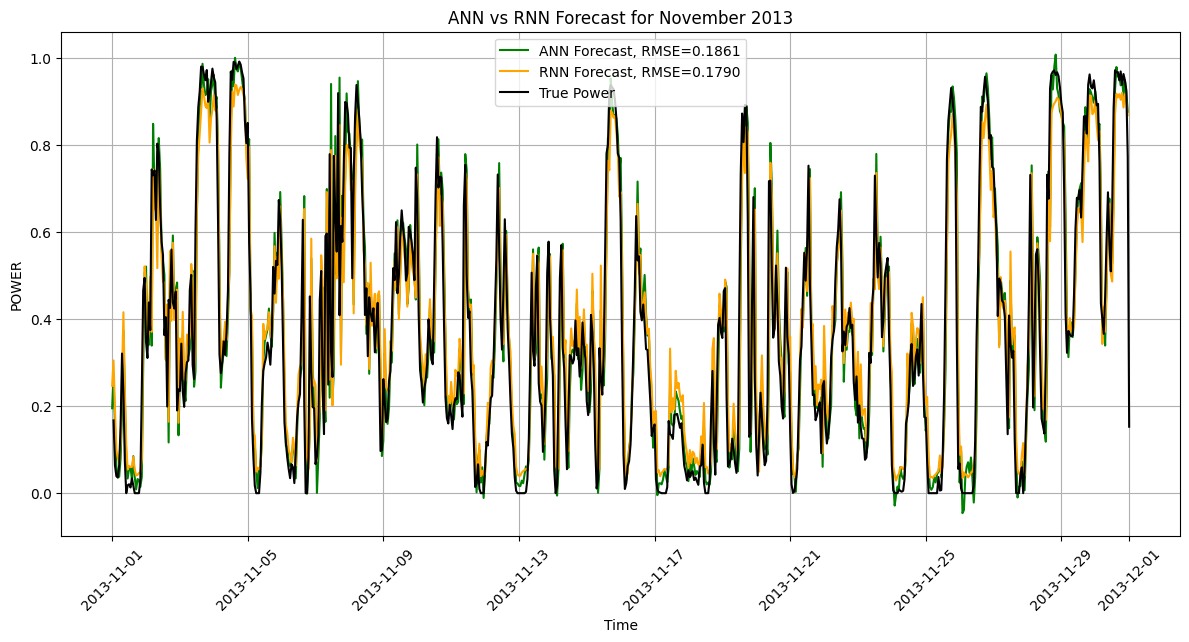

In [61]:
# Plot ANN vs RNN
plt.figure(figsize=(12, 6))
plt.plot(forecast_df['TIMESTAMP'], y_pred_ann, label=f'ANN Forecast, RMSE={rmse_ann:.4f}', color='green')
plt.plot(forecast_df['TIMESTAMP'], y_pred_rnn, label=f'RNN Forecast, RMSE={rmse_rnn:.4f}', color='orange')
plt.plot(solution_df['TIMESTAMP'], solution_df['POWER'], label='True Power', color='black')
plt.xlabel("Time")
plt.ylabel("POWER")
plt.title("ANN vs RNN Forecast for November 2013")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

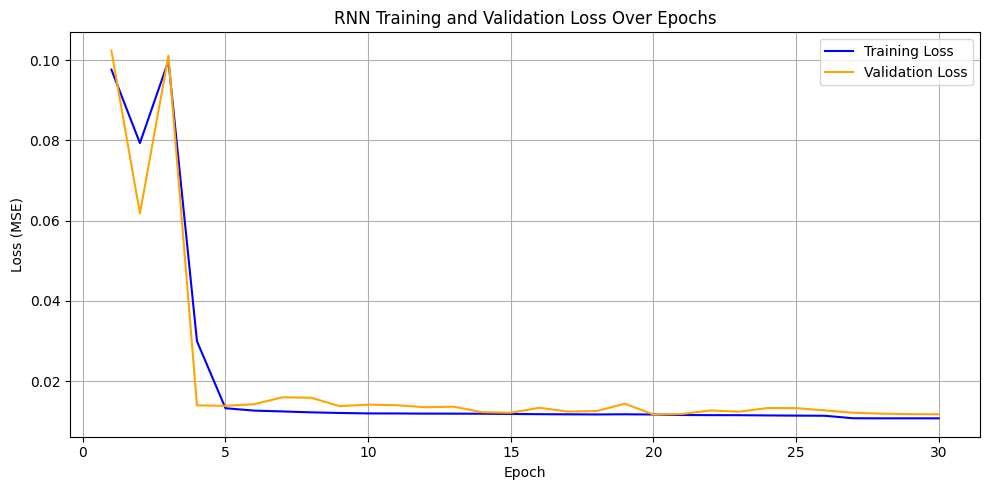

In [62]:
# Plot training and validation loss for RNN
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='orange')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("RNN Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()